# Исследование уязвимости модели nanodet_plus_62_192 к атакам патчами

## Импорты

In [3]:
import PIL
import numpy as np
import os
import torch
from torchvision import transforms
from PIL import Image
from types import SimpleNamespace
from matplotlib import pyplot as plt
import cv2

from art.estimators.object_detection import PyTorchYolo
from art.attacks.evasion import AdversarialPatchPyTorch
from art.attacks.evasion import RobustDPatch

## Вспомогательные функции

In [4]:
COCO_INSTANCE_CATEGORY_NAMES = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
        'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
        'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
        'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
        'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
        'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
        'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
        'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
        'teddy bear', 'hair drier', 'toothbrush']

def get_image_with_boxes(img, labels, confidence=0.15):
    text_size = 1
    text_th = 3
    rect_th = 2

    boxes = labels.get('boxes')
    pred_cls = labels.get('labels')
    scores = labels.get('scores')

    for i in range(len(boxes)):
        if scores[i] >= confidence:
            cv2.rectangle(img, (int(boxes[i][0]), int(boxes[i][1])), (int(boxes[i][2]), int(boxes[i][3])),
                          color=(0, 255, 0), thickness=rect_th)
            cv2.putText(img, f"{COCO_INSTANCE_CATEGORY_NAMES[pred_cls[i]]} {round(float(scores[i]), 2)}",
                        (int(boxes[i][0]), int(boxes[i][1]) - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, text_size, (0, 255, 0), thickness=text_th)

    return img

def show_predictions(patched_images, clean_images, patch_title, model, filename=None):
    clean_preds = model.predict(clean_images)
    patched_preds = model.predict(patched_images)

    # Определяем количество строк (по одному ряду на каждую пару изображений)
    n = len(patched_preds)
    fig, axs = plt.subplots(n, 2, figsize=(9, 4 * n))

    # Если только одно изображение, axs будет 1D, нужно преобразовать в 2D
    if n == 1:
        axs = axs.reshape(1, -1)

    axs[0, 0].set_title("Original")
    axs[0, 1].set_title(patch_title)

    for i in range(n):
        # Оригинальное изображение с bounding box
        im_orig = (clean_images[i]).transpose(1, 2, 0) * 255
        im_orig_boxed = get_image_with_boxes(im_orig.copy(), clean_preds[i])
        axs[i, 0].imshow(im_orig_boxed.astype("uint8"))
        axs[i, 0].axis("off")

        # Патченное изображение с bounding box
        im_adv = (patched_images[i]).transpose(1, 2, 0) * 255
        im_adv_boxed = get_image_with_boxes(im_adv.copy(), patched_preds[i])
        axs[i, 1].imshow(im_adv_boxed.astype("uint8"))
        axs[i, 1].axis("off")

    if filename:
        plt.tight_layout()
        plt.savefig(filename)

def save_patch(patch, filename):
    # 1. Транспонируем в формат (H, W, C)
    patch_hwc = np.transpose(patch, (1, 2, 0))

    # 2. Нормализуем значения (если патч в [-1, 1] или [0, 1])
    if patch_hwc.min() < 0:  # Предполагаем, что патч в [-1, 1]
        patch_hwc = (patch_hwc + 1) * 127.5  # Масштабируем в [0, 255]
    elif patch_hwc.max() <= 1:  # Если патч в [0, 1]
        patch_hwc = patch_hwc * 255

    # 3. Конвертируем в uint8 и сохраняем
    patch_uint8 = patch_hwc.astype(np.uint8)
    Image.fromarray(patch_uint8).save(filename)

## Загрузка датасета

Скачать его можно по [ссылке](https://disk.360.yandex.ru/d/9N-NHwA9xyjMAQ)

In [5]:
NUM_SAMPLES = 200
IMAGE_DIR = "images_for_patch"
IMG_SIZE = 416
NUMBER_CHANNELS = 3
INPUT_SHAPE = (NUMBER_CHANNELS, IMG_SIZE, IMG_SIZE)

# Преобразования
transform = transforms.Compose([
    transforms.Resize(int(INPUT_SHAPE[1]), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(int(INPUT_SHAPE[1])),
    transforms.ToTensor()
])

def get_images(num):
    # Получаем список файлов
    image_files = [os.path.join(IMAGE_DIR, f) for f in os.listdir(IMAGE_DIR)
                   if f.endswith(('.jpg', '.jpeg', '.png'))][:num]
    image_files.sort()

    # Загрузка и преобразование изображений
    coco_images = []
    for img_path in image_files:
        try:
            img = Image.open(img_path)
            if img.mode != 'RGB':
                img = img.convert('RGB')
            img_tensor = transform(img)
            coco_images.append(img_tensor.numpy())
        except Exception as e:
            print(f"Ошибка обработки {img_path}: {str(e)}")

    # Преобразование в numpy array
    return np.array(coco_images)  # (N, 3, 640, 640)

coco_images = get_images(NUM_SAMPLES)

## Загрузка модели

Ввиду особенностей модели, сохраненной в onnx, модель не может принимать на вход более одного изображения за раз, из-за чего во всех экспериментах batch_size придется ставить равным 1

In [6]:
import torch
import numpy as np
import cv2
from art.estimators.object_detection import PyTorchObjectDetector
from typing import Tuple, List, Dict, Any

def _preprocess(img: np.ndarray, size: Tuple[int, int, int], mean: np.ndarray, scale: np.ndarray) -> np.ndarray:
    """Preprocess image: convert to BGR, resize, normalize, and convert to CHW format."""
    # Input img: (C, H, W), [0, 1], RGB
    _, h, w = size
    # Convert to (H, W, C), [0, 255], BGR
    img = img.transpose(1, 2, 0) * 255.0  # (H, W, C), RGB
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # (H, W, C), BGR
    # Resize and normalize
    blob = cv2.resize(img, (w, h)).astype(np.float32)
    return ((blob - mean) / scale).transpose(2, 0, 1)[None, ...]  # (1, C, H, W)

def softmax(x: np.ndarray, axis: int = 1) -> np.ndarray:
    """Compute softmax along specified axis."""
    e = np.exp(x - x.max(axis=axis, keepdims=True))
    return e / e.sum(axis=axis, keepdims=True)

def nms(boxes: np.ndarray, scores: np.ndarray, iou_thr: float = 0.45) -> np.ndarray:
    """Non-Maximum Suppression."""
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    areas = (x2 - x1) * (y2 - y1)
    order = scores.argsort()[::-1]
    keep = []
    while order.size:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])
        w = np.maximum(0, xx2 - xx1)
        h = np.maximum(0, yy2 - yy1)
        inter = w * h
        iou = inter / (areas[i] + areas[order[1:]] - inter + 1e-6)
        inds = np.where(iou <= iou_thr)[0]
        order = order[inds + 1]
    return np.array(keep)

def make_grid_and_strides(in_h: int, in_w: int, strides: List[int]) -> Tuple[np.ndarray, np.ndarray]:
    """Generate grid centers and stride map."""
    centers, stride_map = [], []
    for s in strides:
        fh = np.ceil(in_h / s)
        fw = np.ceil(in_w / s)
        yv, xv = np.meshgrid(np.arange(fh), np.arange(fw), indexing='ij')
        cx = (xv + 0.5) * s
        cy = (yv + 0.5) * s
        pts = np.stack([cx, cy], -1).reshape(-1, 2)
        centers.append(pts)
        stride_map.append(np.full((pts.shape[0],), s, dtype=np.float32))
    return np.concatenate(centers, 0), np.concatenate(stride_map, 0)

def postprocess(pred: np.ndarray, orig_sz: Tuple[int, int], in_sz: Tuple[int, int, int],
                strides: List[int], conf_thr: float, num_classes: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Postprocess model output to bounding boxes, scores, and labels."""
    orig_h, orig_w = orig_sz
    _, in_h, in_w = in_sz
    cls_logits = pred[:, :num_classes]
    regs = pred[:, num_classes:]
    N = cls_logits.shape[0]

    centers, stride_map = make_grid_and_strides(in_h, in_w, strides)
    scores_all = softmax(cls_logits)
    class_ids = np.argmax(scores_all, axis=1)
    scores = scores_all[np.arange(N), class_ids]

    mask = scores > conf_thr
    scores = scores[mask]
    class_ids = class_ids[mask]
    regs = regs[mask]
    centers = centers[mask]
    stride_map = stride_map[mask]

    if scores.size == 0:
        return np.zeros((0, 4)), np.array([]), np.array([])

    num_bins = 8
    regs = regs.reshape(-1, 4, num_bins)
    probs = softmax(regs, axis=2)
    bins = np.arange(num_bins, dtype=np.float32)
    dist = (probs * bins).sum(axis=2) * stride_map[:, None]
    l, t, r, b = dist[:, 0], dist[:, 1], dist[:, 2], dist[:, 3]
    cx, cy = centers[:, 0], centers[:, 1]
    x1, y1 = cx - l, cy - t
    x2, y2 = cx + r, cy + b
    boxes = np.stack([x1, y1, x2, y2], axis=1)

    sx, sy = orig_w / in_w, orig_h / in_h
    boxes[:, [0, 2]] *= sx
    boxes[:, [1, 3]] *= sy

    keep = nms(boxes, scores)
    return boxes[keep], scores[keep], class_ids[keep]

class NanoDetWrapper(PyTorchObjectDetector):
    def __init__(self, model: torch.nn.Module, input_shape: Tuple[int, int], num_classes: int,
                 clip_values: Tuple[float, float] = (0.0, 1.0), device: str = 'cpu'):
        """
        Wrapper for NanoDet model compatible with ART's PyTorchObjectDetector.

        Args:
            model: PyTorch model (converted from ONNX).
            input_shape: Tuple of (height, width) for input images.
            num_classes: Number of classes in the model.
            clip_values: Tuple of (min, max) values for input clipping.
            device: Device to run the model on ('cpu' or 'cuda').
        """
        self._input_shape = input_shape  # Store as (height, width)
        self.num_classes = num_classes
        self.mean = np.array([103.53, 116.28, 123.675], dtype=np.float32)
        self.scale = np.array([57.375, 57.12, 58.395], dtype=np.float32)
        self.strides = [8, 16, 32, 64]
        self.conf_thr = 0.25

        super().__init__(
            model=model,
            input_shape=(3, input_shape[0], input_shape[1]),
            clip_values=clip_values,
            channels_first=True,
            preprocessing=(self.mean, self.scale),
            device_type=device
        )
        self.model.to(self.device)
        self.model.eval()

    @property
    def input_shape(self) -> Tuple[int, int]:
        """Getter for input_shape."""
        return self._input_shape

    @input_shape.setter
    def input_shape(self, value: Tuple[int, int]):
        """Setter for input_shape."""
        self._input_shape = value
        super(NanoDetWrapper, self.__class__).input_shape.fset(self, (3, value[0], value[1]))

    def predict(self, x: np.ndarray, batch_size: int = 128, **kwargs) -> List[Dict[str, np.ndarray]]:
        """
        Perform prediction for a batch of inputs.

        Args:
            x: Input images of shape (N, C, H, W) in range [0, 1], RGB format.
            batch_size: Batch size for processing.

        Returns:
            List of dictionaries with keys 'boxes', 'scores', 'labels' for each image.
        """
        with torch.no_grad():
            predictions = []
            for i in range(0, x.shape[0], batch_size):
                batch = x[i:i + batch_size]  # (N, C, H, W), [0, 1], RGB
                for img in batch:
                    orig_h, orig_w = img.shape[1:]  # Get original H, W from (C, H, W)
                    blob = _preprocess(img, self.input_shape, self.mean, self.scale)
                    pred = self.model(torch.from_numpy(blob).to(self.device))[0].cpu().numpy()
                    boxes, scores, labels = postprocess(
                        pred, (orig_h, orig_w), self.input_shape, self.strides, self.conf_thr, self.num_classes
                    )
                    predictions.append({
                        'boxes': boxes.astype(np.float32),
                        'scores': scores.astype(np.float32),
                        'labels': labels.astype(np.int64)
                    })
        return predictions

    def loss_gradient(self, x: np.ndarray, y: List[Dict[str, np.ndarray]], **kwargs) -> np.ndarray:
        x_torch = torch.from_numpy(x).float().to(self.device)
        x_torch.requires_grad = True

        with torch.enable_grad():
            output = self.model(x_torch)
            if isinstance(output, tuple):
                pred = output[0]  # Assume first output contains predictions
            else:
                pred = output

            loss = 0.0
            num_classes = self.num_classes

            for i in range(x.shape[0]):
                # Process raw model output without leaving PyTorch
                # pred[i] has shape [num_predictions, num_classes + 32] (32 for 4*8)
                cls_logits = pred[i, :, :num_classes]   # [num_predictions, num_classes]
                scores = torch.softmax(cls_logits, dim=1)

                # Get target class indices from y
                target_classes = torch.tensor(y[i]['labels'], device=self.device, dtype=torch.long)

                if len(target_classes) > 0:
                    # Get predicted classes and their scores
                    pred_scores, pred_classes = torch.max(scores, dim=1)  # [num_predictions]

                    # Create mask for predictions that are in target classes
                    class_mask = torch.isin(pred_classes, target_classes)

                    if torch.any(class_mask):
                        # Gather scores for the predicted classes
                        selected_scores = pred_scores[class_mask]

                        # Use negative log likelihood of these scores
                        loss += -torch.log(selected_scores).sum()

            if loss == 0:
                return np.zeros_like(x)

            loss.backward()
            grad = x_torch.grad.cpu().numpy()
        return grad

    def fit(self, x: np.ndarray, y: List[Dict[str, np.ndarray]], batch_size: int = 128, nb_epochs: int = 20, **kwargs):
        """Not implemented as NanoDet is not trained here."""
        raise NotImplementedError("Training is not supported in this wrapper.")

In [8]:
import torch
import onnx
import onnx2torch
import onnxruntime as ort
import cv2
import numpy as np

# Load and convert model
onnx_model = onnx.load('nanodet.onnx')
onnx_runtime = ort.InferenceSession('nanodet.onnx')
model = onnx2torch.convert(onnx_model)
model.input_size = onnx_runtime.get_inputs()[0].shape[1:]
model.output_size = onnx_runtime.get_outputs()[0].shape[1:]
model.num_classes = model.output_size[1] - 32

# Initialize wrapper
detector = NanoDetWrapper(
    model=model,
    input_shape=(416, 416),
    num_classes=model.num_classes,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

## Создание патча

### DPatch

In [9]:
from art.attacks.evasion import DPatch

atk = RobustDPatch(
    detector,
    patch_shape=(3, 160, 160),
    max_iter=5000,
    learning_rate=0.05,
    batch_size=1
)
patch = atk.generate(x=coco_images)
save_patch(patch, 'dpatch5000new.png')

RobustDPatch iteration:   0%|          | 0/500 [00:00<?, ?it/s]


0: 416x416 3 persons, 56.6ms
Speed: 0.5ms preprocess, 56.6ms inference, 105.6ms postprocess per image at shape (1, 3, 416, 416)


AssertionError: expected 6 or 7 values but got 3

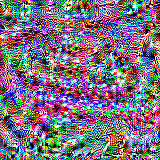

In [24]:
loaded_patch = Image.open('dpatch5000new.png')
loaded_patch

### PGD

In [23]:
from art.attacks.evasion import ProjectedGradientDescent

atk = ProjectedGradientDescent(estimator=detector,
                                      batch_size=1,
                                      max_iter=100,
                               eps=0.1,
                               eps_step=0.01)
results = atk.generate(coco_images)

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

In [24]:
results.shape

(179, 3, 416, 416)

In [25]:
import os
import numpy as np
from PIL import Image

# Создаем папку, если ее нет
os.makedirs('results', exist_ok=True)

# Предполагаем, что results - это numpy array формы (179, 3, 416, 416)
# и значения пикселей в диапазоне [0, 1] или [0, 255]
for i in range(results.shape[0]):
    # Получаем i-ое изображение
    img_array = results[i]

    # Если каналы идут первыми (CHW формат), меняем порядок на HWC
    img_array = np.transpose(img_array, (1, 2, 0))

    # Если значения в [0, 1], масштабируем до [0, 255]
    if img_array.max() <= 1.0:
        img_array = (img_array * 255).astype(np.uint8)
    else:
        img_array = img_array.astype(np.uint8)

    # Создаем изображение PIL и сохраняем
    img = Image.fromarray(img_array)
    img.save(f'results/adv_image_{i:03d}.png')  # или .jpg

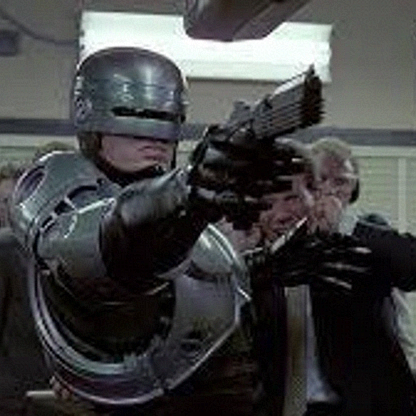

In [19]:
Image.fromarray((np.transpose(results[0], (1, 2, 0)) * 255).astype(np.uint8))

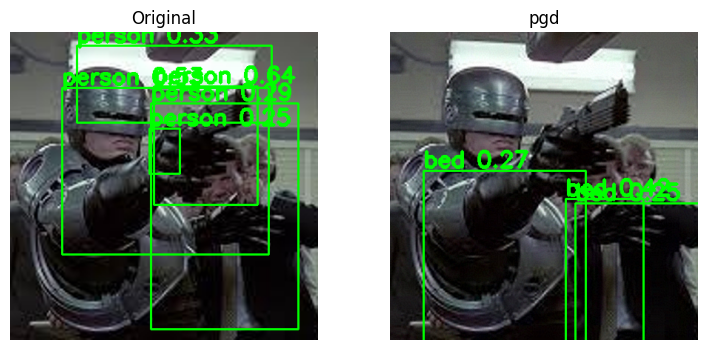

In [21]:
show_predictions(results, coco_images[:1], 'pgd', detector)

# DPatch on YOLO

In [7]:
from types import SimpleNamespace
import torch
from ultralytics import YOLO
from ultralytics.utils.loss import v8DetectionLoss


class YoloWrapper(torch.nn.Module):
    """
    Обертка для модели YOLO, обеспечивающая совместимость с инструментами тестирования атак.

    Поддерживает:
    - Работу с моделями YOLO через ultralytics
    - Расчет потерь для обучения
    - Предсказание с возможностью постобработки

    .. attribute:: orig_model
        Оригинальная модель YOLO.
        :type: YOLO

    .. attribute:: classes
        Список имен классов.
        :type: list

    .. attribute:: model
        Внутренняя модель PyTorch.
        :type: torch.nn.Module

    .. attribute:: predict_count
        Счетчик предсказаний.
        :type: int

    .. attribute:: loss_fn
        Функция потерь для детекции.
        :type: v8DetectionLoss
    """
    def __init__(self, model, **kwargs):
        """
        Инициализация обертки для YOLO модели.

        :param model: Путь к модели или загруженная модель YOLO
        :type model: str or YOLO
        :param kwargs: Дополнительные параметры:
                       - ``tal_topk``: количество топ-k для TAL (Task-Aligned Learning)
                       - ``box``: коэффициент потерь для bounding box
                       - ``cls``: коэффициент потерь для классификации
                       - ``dfl``: коэффициент потерь для Distribution Focal Loss
        :type kwargs: dict

        .. note::
            Модель автоматически переводится в режим оценки (eval), а её параметры замораживаются.
            Функция потерь инициализируется с гиперпараметрами по умолчанию, которые можно переопределить.

        Пример:

        .. code-block:: python

            wrapper = YoloWrapper("yolov8n.pt", box=7.5, cls=0.5, dfl=1.5)
        """
        super().__init__()
        self.orig_model = YOLO(model)
        self.classes = list(self.orig_model.names.values())
        self.model = self.orig_model.model
        self.predict_count = 0

        # Замораживаем параметры модели
        for param in self.model.parameters():
            param.requires_grad = False

        # Инициализация функции потерь
        self.loss_fn = v8DetectionLoss(self.model, tal_topk=kwargs.get("tal_topk", 10))
        self.loss_fn.hyp = SimpleNamespace(box=kwargs.get("box", 7.5),
                                           cls=kwargs.get("cls", 0.5),
                                           dfl=kwargs.get("dfl", 1.5)
        )

    def forward(self, x, targets=None):
        """
        Прямой проход модели.

        :param x: Входной тензор изображения
        :type x: torch.Tensor
        :param targets: Тензор целей для обучения в формате ``[batch_idx, class, x1, y1, x2, y2]``
        :type targets: torch.Tensor, optional
        :return:
            - В режиме обучения: словарь с компонентами потерь
            - В режиме оценки: тензор предсказаний формы ``(n, 8400, 85)``
        :rtype: dict or torch.Tensor

        .. note::
            В режиме обучения возвращается словарь с ключами:
            - ``'loss_box'``: потери для координат bounding box
            - ``'loss_cls'``: потери классификации
            - ``'loss_dfl'``: Distribution Focal Loss

        .. warning::
            В режиме оценки выходной тензор имеет форму ``(n, 8400, 85)``, где:
            - Первые 4 значения — координаты bbox (x1, y1, x2, y2)
            - 5-е значение — objectness score
            - Остальные — оценки классов
        """
        if self.training:
            # Подготовка батча для расчета потерь
            batch = {
                "batch_idx": targets[:, 0].long(),
                "cls": targets[:, 1].long(),
                "bboxes": targets[:, 2:6].float(),
            }
            loss_total, loss_tensor = self.loss_fn(self.model(x), batch)

            loss_dict = {
                'loss_box': loss_total[0],  # Потери для bounding box
                'loss_cls': loss_total[1],  # Потери классификации
                'loss_dfl': loss_total[2]   # Distribution Focal Loss
            }

            return loss_dict

        else:
            # Получение предсказаний модели
            pred = self.model(x)[0]  # (n, 84, 8400)

            # Разделение на компоненты
            boxes = pred[:, 0:4, :]  # Координаты bbox
            class_scores = pred[:, 4:, :]  # Оценки классов

            # Расчет objectness score как максимальной оценки класса
            objectness, _ = class_scores.max(dim=1)  # (n, 8400)
            objectness = objectness.unsqueeze(1)  # (n, 1, 8400)

            # Объединение в формат [x1, y1, x2, y2, obj_score, class_scores...]
            pred = torch.cat([
                boxes,
                objectness,
                class_scores
            ], dim=1)  # -> (n, 85, 8400)

            # Транспонирование в формат [batch, 8400, 85]
            pred = pred.permute(0, 2, 1)

            return pred

    def predict(self, x, postprocess=False):
        """
        Предсказание на входных данных.

        :param x: Входные данные (изображения)
        :type x: np.ndarray or torch.Tensor
        :param postprocess: Флаг постобработки результатов
        :type postprocess: bool
        :return: Список результатов для каждого изображения, где каждый элемент — словарь с ключами:
                 - ``'boxes'``: координаты bounding boxes (форма зависит от `postprocess`)
                 - ``'labels'``: метки классов (строки при `postprocess=True`, иначе int)
                 - ``'scores'``: оценки уверенности
        :rtype: list[dict]

        .. note::
            - При ``postprocess=True`` возвращаются numpy-массивы и строковые метки.
            - При ``postprocess=False`` возвращаются тензоры и целочисленные метки.

        Пример возвращаемого значения:

        .. code-block:: python

            [
                {
                    'boxes': np.array([[100, 50, 200, 150], ...]),
                    'labels': ['cat', 'dog'],
                    'scores': np.array([0.95, 0.87])
                },
                ...
            ]
        """
        self.orig_model.model.eval()
        results = self.orig_model(torch.tensor(x), verbose=False)
        outputs = []
        for result in results:
            if postprocess:
                # Возвращаем numpy массивы с постобработкой
                boxes = result.boxes.xyxy.numpy()
                scores = result.boxes.conf.numpy()
                labels = [result.names.get(int(l), "unk") for l in result.boxes.cls]
            else:
                # Возвращаем тензоры без постобработки
                boxes = result.boxes.xyxy
                scores = result.boxes.conf
                labels = result.boxes.cls.int()

            outputs.append({
                'boxes': boxes,
                'labels': labels,
                'scores': scores
            })
        return outputs

    def train(self, state=True):
        """
        Установка режима обучения/оценки.

        :param state: Флаг режима:
                      - ``True``: режим обучения
                      - ``False``: режим оценки
        :type state: bool

        .. note::
            Метод также устанавливает внутреннее состояние ``self.training``.
            Параметры модели заморожены, поэтому обучение не изменяет веса.

        Пример:

        .. code-block:: python

            wrapper.train(True)   # Перевод в режим обучения
            wrapper.train(False)  # Перевод в режим оценки
        """
        self.model.train() if state else self.model.eval()
        self.training = state

In [18]:
from art.attacks.evasion import DPatch
from ultralytics import YOLO
from art.estimators.object_detection import PyTorchYolo

model = YOLO('yolo11s.pt').to(torch.device('cuda'))
detector = YoloWrapper(model)
cls = PyTorchYolo(detector)

atk = RobustDPatch(
    cls,
    patch_shape=(3, 160, 160),
    max_iter=1500,
    learning_rate=0.05,
    batch_size=8
)
patch = atk.generate(x=coco_images)
save_patch(patch, 'dpatch1500_yolo.png')

RobustDPatch iteration:   0%|          | 0/1500 [00:00<?, ?it/s]

AttributeError: 'int' object has no attribute 'backward'

In [14]:
from art.attacks.evasion import DPatch
from ultralytics import YOLO
from art.estimators.object_detection import PyTorchYolo

model = YOLO('yolo11s.pt').to(torch.device('cuda'))
detector = YoloWrapper(model)
cls = PyTorchYolo(detector,
                      attack_losses=("loss_classifier", "loss_box_reg"))

atk = RobustDPatch(
    cls,
    patch_shape=(3, 160, 160),
    max_iter=5000,
    learning_rate=0.05,
    batch_size=8
)
patch = atk.generate(x=coco_images)
save_patch(patch, 'dpatch5000_yolo.png')

RobustDPatch iteration:   0%|          | 0/5000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [37]:
coco_images.shape

(179, 3, 416, 416)

In [23]:
detector.predict(coco_images)


0: 416x416 2 persons, 2.4ms
1: 416x416 1 handbag, 1 oven, 2.4ms
2: 416x416 1 person, 2.4ms
3: 416x416 1 cat, 2.4ms
4: 416x416 1 person, 2.4ms
5: 416x416 1 person, 1 hair drier, 2.4ms
6: 416x416 1 person, 2.4ms
7: 416x416 2 persons, 1 cell phone, 2.4ms
8: 416x416 1 person, 1 bench, 2.4ms
9: 416x416 1 person, 1 boat, 2.4ms
10: 416x416 3 persons, 2.4ms
11: 416x416 3 persons, 1 cell phone, 2.4ms
12: 416x416 1 person, 1 tie, 1 bottle, 1 wine glass, 2.4ms
13: 416x416 1 person, 1 baseball glove, 2.4ms
14: 416x416 2 persons, 2.4ms
15: 416x416 1 person, 2.4ms
16: 416x416 1 person, 2.4ms
17: 416x416 (no detections), 2.4ms
18: 416x416 (no detections), 2.4ms
19: 416x416 1 person, 1 baseball glove, 2.4ms
20: 416x416 1 person, 2.4ms
21: 416x416 (no detections), 2.4ms
22: 416x416 2 persons, 2.4ms
23: 416x416 1 person, 2.4ms
24: 416x416 1 person, 2 baseball bats, 2.4ms
25: 416x416 1 person, 2.4ms
26: 416x416 1 person, 2.4ms
27: 416x416 1 person, 2.4ms
28: 416x416 3 persons, 1 baseball bat, 2.4ms
29: 

AssertionError: expected 6 or 7 values but got 2